# Prediction of molecular properties using GCN

A tutorial for supervised learning of labels as outputs of graph inputs. <br>
I implemented GCN and GAT to predict molecular properties and observed better results from GAT. <br>
Please refer to the following article for the whole contents. <br>
Ryu, Seongok, Jaechang Lim, and Woo Youn Kim. "Deeply learning molecular structure-property relationships using graph attention neural network." arXiv preprint arXiv:1805.10988 (2018).

There is a key difference between the node classification and prediction of labels from whole graph inputs. The later task has to satisfy permutation invariance with respect to changing node orders. Therefore, we will implement readout functions which satisfy the permutation invariance in this tutorial.

In [1]:
import tensorflow as tf
from IPython.display import Image

/Users/Lulu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Overall architecture is as below.

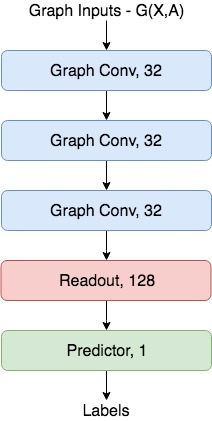

In [2]:
Image('./figures/gcn_prediction.jpg')

Let's assume that shapes of the adjacency matrix, feature matrix are same as the shapes of the matrix used in a 'gcn-node_classification' tutorial.

In [3]:
num_nodes = 50
num_features = 50
X = tf.placeholder(tf.float64, [None, num_nodes, num_features])
A = tf.placeholder(tf.float64, [None, num_nodes, num_nodes])
Y_truth = tf.placeholder(tf.float64, [None,])

An implementation of graph convolution layer is same also.

In [4]:
def graph_conv(_X, _A, output_dim):
    output = tf.layers.dense(_X, units=output_dim, use_bias=True)
    output = tf.matmul(_A, output)
    output = tf.nn.relu(output)
    return output

We have to implement the readout function as described above. <br> 
There are two types of the implementation: node-wise summation (nw) and graph gathering (gg). <br>
Equations are as follow, respectively.

$$ R_{nw} = \tau(\sum_{i \in G} MLP(H_{i}^{L})) $$
$$ R_{gg} = \tau(\sum_{i \in G} \sigma(MLP_1(H_{i}^{L} | H_{i}^{0})) \odot MLP_2(H_{i}^{L}))$$

Notations :
* $ \tau $  : ReLU activation (or other non-linear activations)
* $ \sigma $ : sigmoid activation
* $ \odot $ : elementwise-multiplication - Hadamard product 
* $ (\cdot|\cdot) $ : concatenation
    
Please refer to the following article for the more detail. <br>
Gilmer, Justin, et al. "Neural message passing for quantum chemistry." arXiv preprint arXiv:1704.01212 (2017).

In [5]:
def readout_nw(_X, output_dim):
    # _X : final node embeddings
    output = tf.layers.dense(_X, output_dim, use_bias=True)
    output = tf.reduce_sum(output, axis=1)
    output = tf.nn.relu(output)
    
    return output

In [6]:
def readout_gg(_X, X, output_dim):
    # _X : final node embeddings
    # X : initial node features
    val1 = tf.layers.dense(tf.concat([_X, X], axis=2), output_dim, use_bias=True)
    val1 = tf.nn.sigmoid(val1)
    val2 = tf.layers.dense(_X, output_dim, use_bias=True)
    output = tf.multiply(val1, val2)
    output = tf.reduce_sum(output, axis=1)
    output = tf.nn.relu(output)
    
    return output

We finished preparing necessary functions in the architecture. <br>
Therefore, the implementation of the overall architecture is as below.

In [7]:
gconv1 = graph_conv(X, A, 32)
gconv2 = graph_conv(gconv1, A, 32)
gconv3 = graph_conv(gconv2, A, 32)
graph_feature = readout_gg(gconv3, gconv1, 128)
graph_feature

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float64>

In [8]:
Y_pred = tf.layers.dense(graph_feature, 128, use_bias=True, activation=tf.nn.relu)
Y_pred = tf.layers.dense(Y_pred, 128, use_bias=True, activation=tf.nn.tanh)
Y_pred = tf.layers.dense(Y_pred, 1, use_bias=True, activation=None)
Y_pred

<tf.Tensor 'dense_7/BiasAdd:0' shape=(?, 1) dtype=float64>

A loss function have to be minimized in this task is an l2-norm.

In [9]:
Y_pred = tf.reshape(Y_pred, shape=[-1])
Y_truth = tf.reshape(Y_truth, shape=[-1])
loss = tf.reduce_mean(tf.pow(Y_truth - Y_pred,2))
loss

<tf.Tensor 'Mean:0' shape=() dtype=float64>

Yes, we have completed all necessary preparations for training.

I upload all codes which implement the supervised learning of prediction molecular properties at the 'gnn-molecule' folder. <br>
Scripts for preprocessing also exist. Hope you enjoy the graph neural networks from this moment!
